# PEtab import

This illustrates how the PEtab format can be used together with the ODE simulation toolbox AMICI to define ODE based parameter estimation problems for pyABC.

To use this functionality, you need to have (at least) PEtab and AMICI installed. You can obtain these by installing pyABC with

    pip install pyabc[amici-petab]
    
or installing them manually via

    pip install petab amici

In [1]:
import petab
import pyabc
import amici.petab_import
from pyabc.petab import AmiciPetabImporter
import numpy as np

In [14]:
petab_problem = petab.Problem.from_yaml("/home/icb/yannik.schaelte/benchmark-models/"
                                        "hackathon_contributions_new_data_format/"
                                        "Boehm_JProteomeRes2014/Boehm_JProteomeRes2014.yaml")
model = amici.petab_import.import_petab_problem(petab_problem)
solver = model.getSolver()

importer = AmiciPetabImporter(petab_problem, model, solver)

prior = importer.create_prior()
model = importer.create_model()
kernel = importer.create_kernel()

model(petab_problem.x_nominal_free_scaled)

2020-02-12 13:39:00.771 - amici.petab_import - INFO - Successfully loaded model Boehm_JProteomeRes2014 from /home/icb/yannik.schaelte/pyabc/doc/examples/amici_models/Boehm_JProteomeRes2014.
INFO:amici.petab_import:Successfully loaded model Boehm_JProteomeRes2014 from /home/icb/yannik.schaelte/pyabc/doc/examples/amici_models/Boehm_JProteomeRes2014.


{'llh': -138.2219957033097}

In [16]:
# this takes some time

sampler = pyabc.MulticoreEvalParallelSampler(n_procs=20)

class PDFNorm:

    def __init__(self):
        self.hit = False

    def __call__(
            self,
            prev_pdf_norm, get_weighted_distances, prev_temp, acceptance_rate, **kwargs):
        pdf_norm = pyabc.pdf_norm_max_found(prev_pdf_norm=prev_pdf_norm, get_weighted_distances=get_weighted_distances)
        if prev_temp is None or (acceptance_rate >= 0.1 and not self.hit):
            return pdf_norm
        self.hit = True
        temp = 0.5 * prev_temp
        offset = temp * np.log(10)
        used_norm = pdf_norm - offset
        used_norm = max(prev_pdf_norm, used_norm)
        return used_norm

abc = pyabc.ABCSMC(model, prior, kernel, 
                   eps=pyabc.Temperature(),
                   acceptor=pyabc.StochasticAcceptor(pdf_norm_method=PDFNorm()),
                   sampler=sampler,
                   population_size=1000)
abc.new("sqlite:///petab_amici_boehm.db", {})
abc.run()

INFO:History:Start <ABCSMC(id=1, start_time=2020-02-12 13:39:18.202863, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 92961981.16448309.
INFO:ABC:Acceptance rate: 1000 / 3265 = 3.0628e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 3329.008615165818.
INFO:ABC:Acceptance rate: 1000 / 3636 = 2.7503e-01, ESS=2.5870e+02.
INFO:ABC:t: 2, eps: 171.40222777992136.
INFO:ABC:Acceptance rate: 1000 / 3314 = 3.0175e-01, ESS=4.0645e+02.
INFO:ABC:t: 3, eps: 85.70111388996068.
INFO:ABC:Acceptance rate: 1000 / 6465 = 1.5468e-01, ESS=2.4552e+02.
INFO:ABC:t: 4, eps: 42.85055694498034.
INFO:ABC:Acceptance rate: 1000 / 19019 = 5.2579e-02, ESS=8.2657e+01.
INFO:ABC:t: 5, eps: 21.42527847249017.
INFO:ABC:Acceptance rate: 1000 / 75608 = 1.3226e-02, ESS=3.4768e+02.
INFO:ABC:t: 6, eps: 10.712639236245085.
INFO:ABC:Acceptance rate: 1000 / 127024 = 7.8725e-03, ESS=4.0069e+01.
INFO:ABC:t: 7, eps: 5.3563196181225425.
INFO:ABC:Acceptance rate: 1000 / 360773 = 2.7718e-03, ESS=3.3106e+01.
INFO:AB

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
I

INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Transition density is zero!
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2020-02-12 13:39:18.202863, end_t

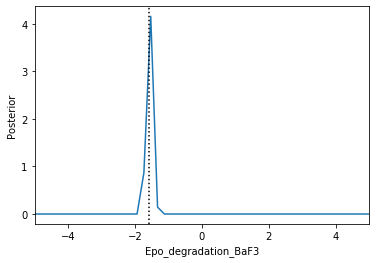

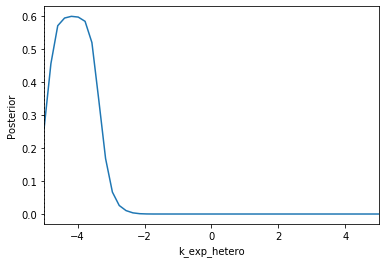

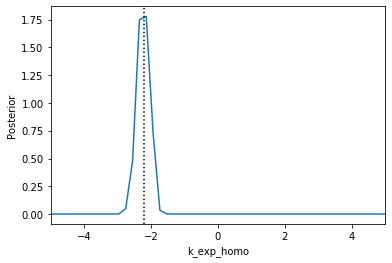

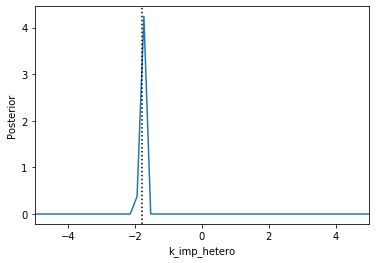

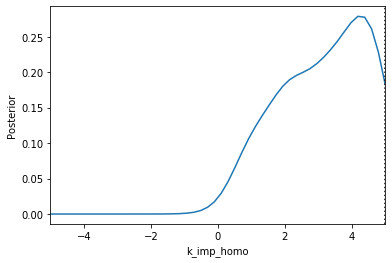

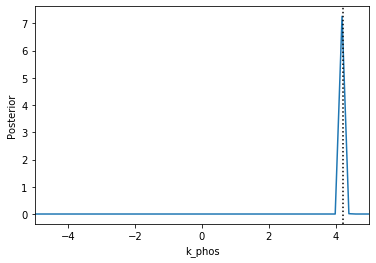

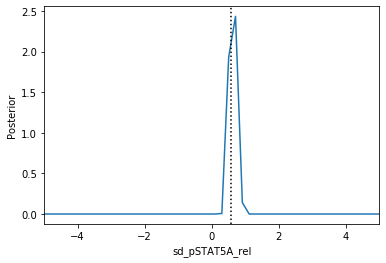

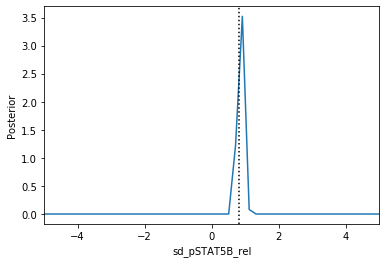

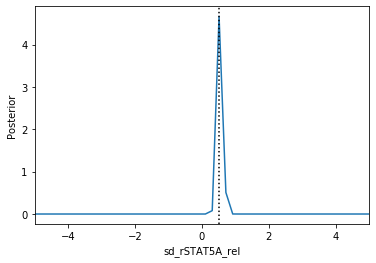

In [25]:
h = pyabc.History("sqlite:///petab_amici_boehm.db")
pdf = petab_problem.parameter_df
refval = {k: v for k,v in zip(petab_problem.x_free_ids, petab_problem.x_nominal_free_scaled)}
for i, par in enumerate(petab_problem.x_free_ids):
    pyabc.visualization.plot_kde_1d_highlevel(
        h, x=par,
        xmin=petab_problem.get_lb(scaled=True,fixed=False)[i],
        xmax=petab_problem.get_ub(scaled=True,fixed=False)[i],
        refval=refval, refval_color='k')